In [1]:
# Update gensim to last version
!pip install gensim --upgrade

     |████████████████████████████████| 24.1 MB 68.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


**Objective**: Find behaviour patterns in driver activities via clustering. (Manually) Classify this patterns to help recognize common faults while driving.

Example: Frequently missing B_T3 after a B_T2, making the hole sequence illegal.

Things worth considering:
- Variable length sequences.
- Activity representation. Possibilities:
  - activity, daytype, sequence, breaktype, token, legal -> [2,0,1,0,1]
  - Not sure if we should consider duration. In that case, should be normalized?
    - Maybe not because we are keeping token, and thus there would be redundant information
- Sequence representation. Possibilities:
  - List of activities (should span a day at most)
  - One activity at a time
  - Just one Sequence
- Distance function depends on the two previous points. Possibilities:
  - Substract duration and for the rest of variables only consider if they are the same. Probably different weights, as legal is more valuable.
- Categorical variables. We need to be careful with the distance function

---

Possible method:
1. Coding activities as word in a list representation
2. Group activities as sentences according to the Sequence column
3. Group sentences as documents, one for each driver
4. Apply sentence clustering or topic modelling (LDA?)

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder

# BOW-TFIDF
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc

# D2V
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Clustering
from sklearn.cluster import KMeans

# Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Silhouette analysis and other clutering metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import matplotlib.cm as cm

----
# Functions

In [11]:
#########################################################################
# Visualize embeddings
#########################################################################

def plot_tsne(matrix, clusters=None, ax=None):
  ax = ax or plt.gca()

  # TSNE
  tsne = TSNE(n_components=2, random_state=12345)
  X_tsne = tsne.fit_transform(matrix)
  df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])

  ax.scatter(df_tsne['x'], df_tsne['y'], alpha=0.5, c=clusters)
  ax.set_title('TSNE')

# -------------------------------------------------------------------------

def plot_pca(matrix, clusters=None, ax=None):
  ax = ax or plt.gca()

  # PCA
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(matrix)
  df_pca = pd.DataFrame(X_pca, columns=['x', 'y'])

  ax.scatter(df_pca['x'], df_pca['y'], alpha=0.5, c=clusters)
  ax.set_title('2D PCA')
  
# -------------------------------------------------------------------------

def plot_3d_pca(matrix, clusters=None, ax=None):
  ax = ax or plt.gca()

  # PCA
  pca = PCA(n_components=3)
  X_pca = pca.fit_transform(matrix)
  df_pca = pd.DataFrame(X_pca, columns=['x', 'y', 'z'])

  ax.scatter3D(df_pca['x'], df_pca['y'], df_pca['z'], alpha=0.5, c=clusters)
  ax.set_title('3D PCA')

# -------------------------------------------------------------------------

def visualize_data(matrix, model_name, clusters=None, ax1=None, ax2=None):
  fig = plt.figure(figsize=(27,6))
  fig.suptitle('{} document plots'.format(model_name))

  ax1 = fig.add_subplot(131)
  ax2 = fig.add_subplot(132)
  ax3 = fig.add_subplot(133, projection='3d')

  plot_tsne(matrix, ax=ax1, clusters=clusters)
  plot_pca(matrix, ax=ax2, clusters=clusters)
  plot_3d_pca(matrix, ax=ax3, clusters=clusters)

  plt.show()

---

In [15]:
#########################################################################
# Silhouette analysis
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
#########################################################################

def plot_silhouette(X, n_clusters, cluster_labels, ax=None):
  ax = ax or plt.gca()

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax.set_xlim([-0.2, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(X, cluster_labels)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(X, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax.set_title("Silhouette plot for the various clusters: {}".format(round(silhouette_avg,3)))
  ax.set_xlabel("Silhouette coefficient values")
  ax.set_ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax.set_yticks([])  # Clear the yaxis labels / ticks

  xticks = [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticks, rotation=40)

In [29]:
def silhouette_analysis(X, range_n_clusters):

  for n_clusters in range_n_clusters:
      # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
      fig.set_size_inches(30, 10)

      # Initialize the clusterer with n_clusters value and a random generator
      clusterer = KMeans(n_clusters=n_clusters, random_state=12345)
      cluster_labels = clusterer.fit_predict(X)

      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

      plot_silhouette(X, n_clusters, cluster_labels, ax1)
      plot_tsne(X, clusters=colors, ax=ax2)
      plot_pca(X, clusters=colors, ax=ax3)

      plt.suptitle(
          "Silhouette analysis for KMeans clustering with n_clusters = %d"
          % n_clusters,
          fontsize=14,
          fontweight="bold",
      )


  plt.show()

In [21]:
#########################################################################
# Take metrics for different K values in K-means
# https://stackoverflow.com/questions/65991074/how-to-find-most-optimal-number-of-clusters-with-k-means-clustering-in-python
#########################################################################

def evaluate_num_clusters(X, plot=True):
  fitted_kmeans = {}
  labels_kmeans = {}
  df_scores = []
  k_values_to_try = np.arange(10, 31)

  for n_clusters in k_values_to_try:
      
      # Perform clustering
      kmeans = KMeans(n_clusters=n_clusters, random_state=12345)
      labels_clusters = kmeans.fit_predict(X)
      
      # Insert fitted model and calculated cluster labels in dictionaries,
      # for further reference
      fitted_kmeans[n_clusters] = kmeans
      labels_kmeans[n_clusters] = labels_clusters
      
      # Calculate various scores, and save them for further reference.
      silhouette = silhouette_score(X, labels_clusters)
      ch = calinski_harabasz_score(X, labels_clusters)
      db = davies_bouldin_score(X, labels_clusters)
      tmp_scores = {"n_clusters": n_clusters,
                    "silhouette_score": silhouette,
                    "calinski_harabasz_score": ch,
                    "davies_bouldin_score": db,
                    }
      df_scores.append(tmp_scores)

      #-------------------------------------------------------------------------
      # Plot silhouette

      # Create a subplot with 1 row and 2 columns
      if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(30, 10)

        colors = cm.nipy_spectral(labels_clusters.astype(float) / n_clusters)

        plot_silhouette(X, n_clusters, labels_clusters, ax1)
        plot_tsne(X, clusters=colors, ax=ax2)
        plot_pca(X, clusters=colors, ax=ax3)

        plt.suptitle(
            "Silhouette analysis for KMeans clustering with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

        plt.show()


  #Create a DataFrame of clustering scores, using `n_clusters` as index, for easier plotting.
  df_scores = pd.DataFrame(df_scores)
  df_scores.set_index("n_clusters", inplace=True)

  return df_scores, fitted_kmeans, labels_kmeans

---

In [37]:
#########################################################################
# Plot a dendogram
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
#########################################################################

from scipy.cluster.hierarchy import dendrogram

# Create linkage matrix and then plot the dendrogram
def plot_dendrogram(model, **kwargs):

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

---

In [46]:
#########################################################################
# Get decoded centroids for Doc2Vec
#########################################################################

# Receives an encoding: String 'x-x-x-x-x-x'
def undo_encoding(x):
  l = x.split('-')
  return [int(e) for e in l]

# Receives a document (n_activities, 1)
def v_undo_encoding(x):
  return [undo_encoding(e) for e in x]

# ------------------------------------------------------------------------------

# If an embedded document is (n_samples, n_variables)
# Expects shape: (n_clusters, n_variables)
def get_decoded_centroids_d2v(centroids):
  # For each centroid get the most similar document
  centroid_docs = []
  for cent in centroids:
    doc, similarity = doc2vec.dv.most_similar(positive = [cent], topn=1)[0]
    centroid_docs.append(doc)

  # Get the content of each doc
  docs = []
  for c_doc in centroid_docs:
    docs.append(corpus_lists[c_doc])

  # -----------------------------------------------

  # Get input format for inverse_encoder
  encoded_centroids = list(map(v_undo_encoding, docs))

  # Decode each centroid
  decoded_centroids = []
  for centroid in encoded_centroids:
    # Expects list(list(decoded_activity))
    # e.g: [[1, 1, 4, 3, 0, 1], [3, 1, 4, 3, 0, 1]]
    b = ordinalencoder_X.inverse_transform(centroid)
    
    decoded_centroids.append(b)

  # -----------------------------------------------
  # Get centroids as DataFrame

  cols = ['Activity', 'DayType', 'Sequence', 'BreakType', 'Token', 'Legal']

  df_centroids = pd.DataFrame(columns=cols)

  for c, number in zip(decoded_centroids, range(len(decoded_centroids))):
    df_c = pd.DataFrame(c, columns=cols)
    df_c["Cluster"] = number

    df_centroids = df_centroids.append(df_c)

  return df_centroids

---
---

In [3]:
#########################################################################
# Load data
#########################################################################
data_path = "./combined-log.csv"
df = pd.read_csv(data_path, sep="\t",)

# To timestamp format
df.DateTimeStart = pd.to_datetime(df.DateTimeStart)
df.DateTimeEnd = pd.to_datetime(df.DateTimeEnd)

# Rename column
df = df_original = df.rename(columns={"#Driver":"Driver", "Duration(min)":"Duration"})


# To numerical
df.Legal = df.Legal.map({"yes": 1, "no": 0}) # Not sure if [-1,1] is better

# Drop columns
df = df.drop(columns=['Duration', 'ZenoInfo', "DateTimeStart", "DateTimeEnd", 'Week'])

df

Driver Activity   Day DayType Sequence      BreakType  Token  Legal
0        driver1    Break   1.0     ndd    first        split_1   B_T0      1
1        driver1  Driving   1.0     ndd    first        split_1      A      1
2        driver1    Other   1.0     ndd    first        split_1      A      1
3        driver1  Driving   1.0     ndd    first        split_1      A      1
4        driver1    Other   1.0     ndd    first        split_1      A      1
...          ...      ...   ...     ...      ...            ...    ...    ...
27163  driver188    Break  11.0     ndd   unique  uninterrupted  DR_T3      1
27164  driver188     Idle  12.0     ndd   unique  uninterrupted      I      1
27165  driver188    Break  12.0     ndd   unique  uninterrupted   B_T0      1
27166  driver188     Idle  12.0     ndd   unique  uninterrupted      I      1
27167  driver188    Break  12.0     ndd   unique  uninterrupted  DR_T4      1

[27168 rows x 8 columns]

In [4]:
#########################################################################
# Transform data
# Encode each column as numeric and group them
#########################################################################

# The encoded columns are:
# Activity - DayType - Sequence - BreakType - Token - Legal

# Reorder columns
cols = ['Driver', 'Day', 'Activity', 'DayType', 'Sequence', 'BreakType', 'Token', 'Legal']
df = df[cols]

x = df.to_numpy()

# Encode into ordinal numbers
ordinalencoder_X = OrdinalEncoder(dtype=np.int8)
x[:,2:] = ordinalencoder_X.fit_transform(x[:,2:])

df_encoded = pd.DataFrame(x, columns=cols)

# Group columns into one (as string)
df_encoded['Encoding'] = df_encoded[df_encoded.columns[2:]].apply(
                            lambda x: '-'.join(x.dropna().astype(str)),
                            axis=1
                        )

# Remove encoded columns
df_encoded = df_encoded[['Driver','Day','Encoding']]

df_encoded

Driver Day     Encoding
0        driver1   1  0-1-0-1-1-1
1        driver1   1  1-1-0-1-0-1
2        driver1   1  3-1-0-1-0-1
3        driver1   1  1-1-0-1-0-1
4        driver1   1  3-1-0-1-0-1
...          ...  ..          ...
27163  driver188  11  0-1-4-3-7-1
27164  driver188  12  2-1-4-3-9-1
27165  driver188  12  0-1-4-3-1-1
27166  driver188  12  2-1-4-3-9-1
27167  driver188  12  0-1-4-3-8-1

[27168 rows x 3 columns]

In [5]:
# Group activities by day and join them in a list

# For each driver append all Encodings of one Day into a list
groups = df_encoded.groupby('Driver', sort=False) # False to keep driver ordering

# Each sentence is the sequence of activities in a day
corpus_lists = []

for name, group in groups:
  a = group.drop(columns='Driver')
  g = a.groupby('Day').cumcount()
  L = (a.set_index(['Day',g])
        .stack().groupby(level=0)
        .apply(lambda x: x.values))

  corpus_lists.extend(L)

In [70]:
print("Number of unique sequences: {}".format(len(df_encoded.Encoding.unique())))
# df_encoded.Encoding.unique()

Number of unique sequences: 152


---
- Word: Encoded activity
- Document: Words for a day (no matter the week or the driver)
---

In [10]:
#########################################################################
# Get embeddings
# Bag-of-words and TF-IDF
# 
# It seem it will work without considering order (maybe because the tags already
# add information about it?)
# 
# https://stackoverflow.com/questions/50933591/how-to-perform-kmean-clustering-from-gensim-tfidf-values
#########################################################################

# Get the dictionary of our corpus
dictionary = Dictionary(corpus_lists)
num_docs = dictionary.num_docs
num_terms = len(dictionary.keys())

# Transform into bow (bag-of-words)
# It's a small dictionary so I think this representation shouldn't be a problem
corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_lists]

# Transform into tf-idf (term frequency – inverse document frequency)
tfidf = TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

# Transform into sparse/dense matrix:
corpus_tfidf_dense = corpus2dense(corpus_tfidf, num_terms, num_docs).T   # Transposed!
# corpus_tfidf_sparse = corpus2csc(corpus_tfidf, num_terms, num_docs)

In [114]:
#########################################################################
# Get embeddings
# Paragraph Vector (Doc2Vec)
# Word2vec for all the documents
#########################################################################

# Tag documents
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_lists)]

# Define and initialize model
doc2vec = Doc2Vec(documents, vector_size=150, epochs=30, min_count=30, seed=12345)

# Train model
doc2vec.train(documents, 
              total_examples=doc2vec.corpus_count, 
              epochs=doc2vec.epochs)

In [115]:
# Evaluate doc2vec model

ranks = []
second_ranks = []
for doc_id in range(len(documents)):
    inferred_vector = doc2vec.infer_vector(documents[doc_id].words)
    sims = doc2vec.dv.most_similar([inferred_vector], topn=len(doc2vec.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [116]:
import collections

counter = collections.Counter(ranks)

print("Number of documents: {}".format(len(documents)))
print(counter)
print("Inferred documents similar to itself: {}%".format(counter[0]/len(documents) * 100))

Number of documents: 1694
Counter({0: 395, 1: 103, 2: 73, 3: 52, 4: 49, 5: 36, 6: 35, 7: 28, 10: 25, 9: 24, 13: 23, 14: 19, 18: 19, 16: 18, 27: 16, 23: 15, 15: 14, 8: 14, 22: 14, 11: 14, 20: 12, 12: 11, 17: 11, 24: 10, 38: 10, 25: 9, 19: 9, 21: 9, 56: 8, 33: 8, 31: 8, 36: 8, 43: 8, 46: 7, 59: 7, 40: 7, 54: 7, 52: 7, 61: 7, 85: 7, 41: 7, 60: 7, 35: 7, 28: 6, 32: 6, 42: 6, 29: 6, 34: 6, 37: 5, 66: 5, 50: 5, 105: 5, 100: 5, 48: 5, 57: 5, 53: 5, 39: 5, 102: 4, 47: 4, 80: 4, 30: 4, 106: 4, 63: 4, 49: 4, 90: 4, 127: 4, 26: 4, 45: 4, 75: 4, 151: 4, 58: 4, 88: 3, 129: 3, 141: 3, 101: 3, 154: 3, 247: 3, 71: 3, 173: 3, 74: 3, 82: 3, 72: 3, 148: 3, 67: 3, 134: 3, 139: 3, 62: 3, 138: 3, 68: 3, 51: 3, 140: 3, 250: 3, 113: 3, 179: 3, 143: 3, 89: 3, 91: 3, 69: 3, 83: 3, 187: 3, 117: 3, 716: 2, 1077: 2, 95: 2, 81: 2, 133: 2, 418: 2, 396: 2, 183: 2, 193: 2, 242: 2, 73: 2, 156: 2, 449: 2, 65: 2, 164: 2, 126: 2, 276: 2, 104: 2, 112: 2, 103: 2, 111: 2, 373: 2, 76: 2, 300: 2, 182: 2, 142: 2, 97: 2, 130: 2,

In [117]:
# Get embedding for each document
embeddings_d2v = []

for sentence in corpus_lists:
  embeddings_d2v.append(
      doc2vec.infer_vector(sentence)
  )

---

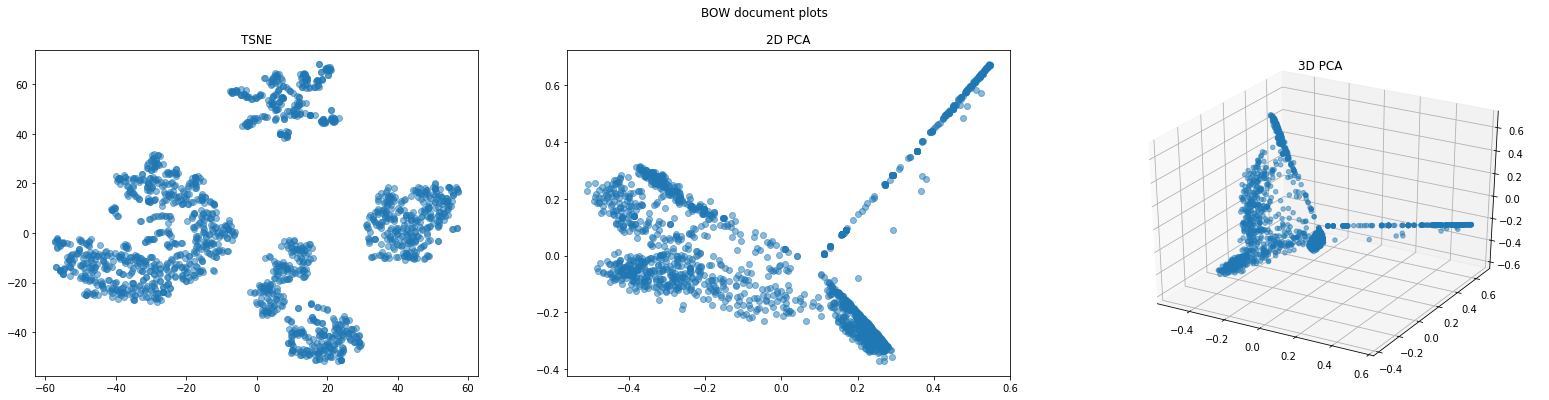

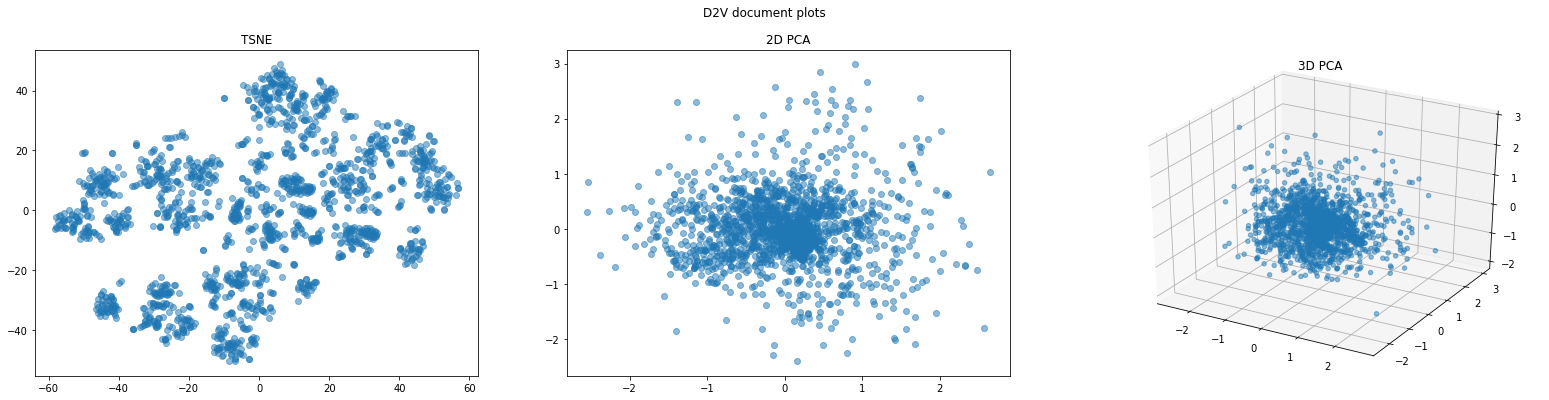

In [103]:
visualize_data(corpus_tfidf_dense, 'BOW')
visualize_data(embeddings_d2v, 'D2V')

Apparently not a good dataset for clustering. High density and not clear partitions (although it must be noted that we are visualizing 2 dimensions from >100)

---
## K-MEANS

KMeans assumes that clusters are convex shaped (in order to calculate the proper centroids). I'm not sure if our data takes this shape, but I'll try this method and compare it with others

In [118]:
#########################################################################
# Train data
# KMeans clustering (Euclidean distance)
#########################################################################

n_clusters = 10

# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=12345)

# clusters_bow = kmeans.fit_predict(corpus_tfidf_dense)
# centroid_bow = kmeans.cluster_centers_

clusters_d2v = kmeans.fit_predict(embeddings_d2v)
centroid_d2v = kmeans.cluster_centers_

In [119]:
print("Mean Silhouette Coefficient - BOW: %0.3f" % silhouette_score(corpus_tfidf_dense, clusters_bow))
print("Mean Silhouette Coefficient - D2V: %0.3f" % silhouette_score(embeddings_d2v, clusters_d2v))

Mean Silhouette Coefficient - BOW: 0.159
Mean Silhouette Coefficient - D2V: 0.091


# Silhouette Coefficient
If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

s = (b-a) / max(a,b) 

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

## Advantages
- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

## Drawbacks
- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

# Calinski-Harabasz Index
If the ground truth labels are not known, the Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

## Advantages
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
- The score is fast to compute.

## Drawbacks
- The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

# Davies-Bouldin Index
If the ground truth labels are not known, the Davies-Bouldin index (sklearn.metrics.davies_bouldin_score) can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters.

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Zero is the lowest possible score. Values closer to zero indicate a better partition.

## Advantages
- The computation of Davies-Bouldin is simpler than that of Silhouette scores.
- The index is solely based on quantities and features inherent to the dataset as its computation only uses point-wise distances.

## Drawbacks
- The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.
- The usage of centroid distance limits the distance metric to Euclidean space.

In [48]:
bow_df_scores, bow_fitted_kmeans, bow_labels_kmeans = evaluate_num_clusters(corpus_tfidf_dense, plot=False)
bow_df_scores

In [49]:
bow_df_scores

silhouette_score  calinski_harabasz_score  davies_bouldin_score
n_clusters                                                                 
10                  0.158832               122.446257              2.316693
11                  0.148292               115.769759              2.284723
12                  0.159926               110.322641              2.284331
13                  0.154421               105.670588              2.262454
14                  0.149484               100.821900              2.274492
15                  0.152848                97.959875              2.174063
16                  0.147228                95.932017              2.182649
17                  0.143621                92.661811              2.185050
18                  0.144372                89.705101              2.156275
19                  0.138981                88.297507              2.105935
20                  0.142012                85.698514              2.148892
21                  0.146440                85.471310              2.038888
22                  0.144751                83.199007              2.044478
23                  0.139534                81.028166              2.098436
24                  0.150017                79.533382              2.030078
25                  0.151541                77.983048              1.980219
26                  0.148084                75.865190              1.983577
27                  0.154211                75.580961              1.997277
28                  0.147706                74.133487              1.956887
29                  0.148605                72.701550              1.970082
30                  0.155263                72.084893              1.997931

Given the large number of days in our dataset I'm not fond to believe that a small number of clusters (< 15) is a good value.

Although it may seem to have better defined clusters (good silhouette and calinski values) I would consider that number only if we aim to get the smallest possible number of clusters.


Silhouette and Davies scores start to increase at 24 but past 30 could be an excessive quantity.

**Overall not a good partition with any number, but considering how awfully distributed is our data I don't think we can expect much better results**

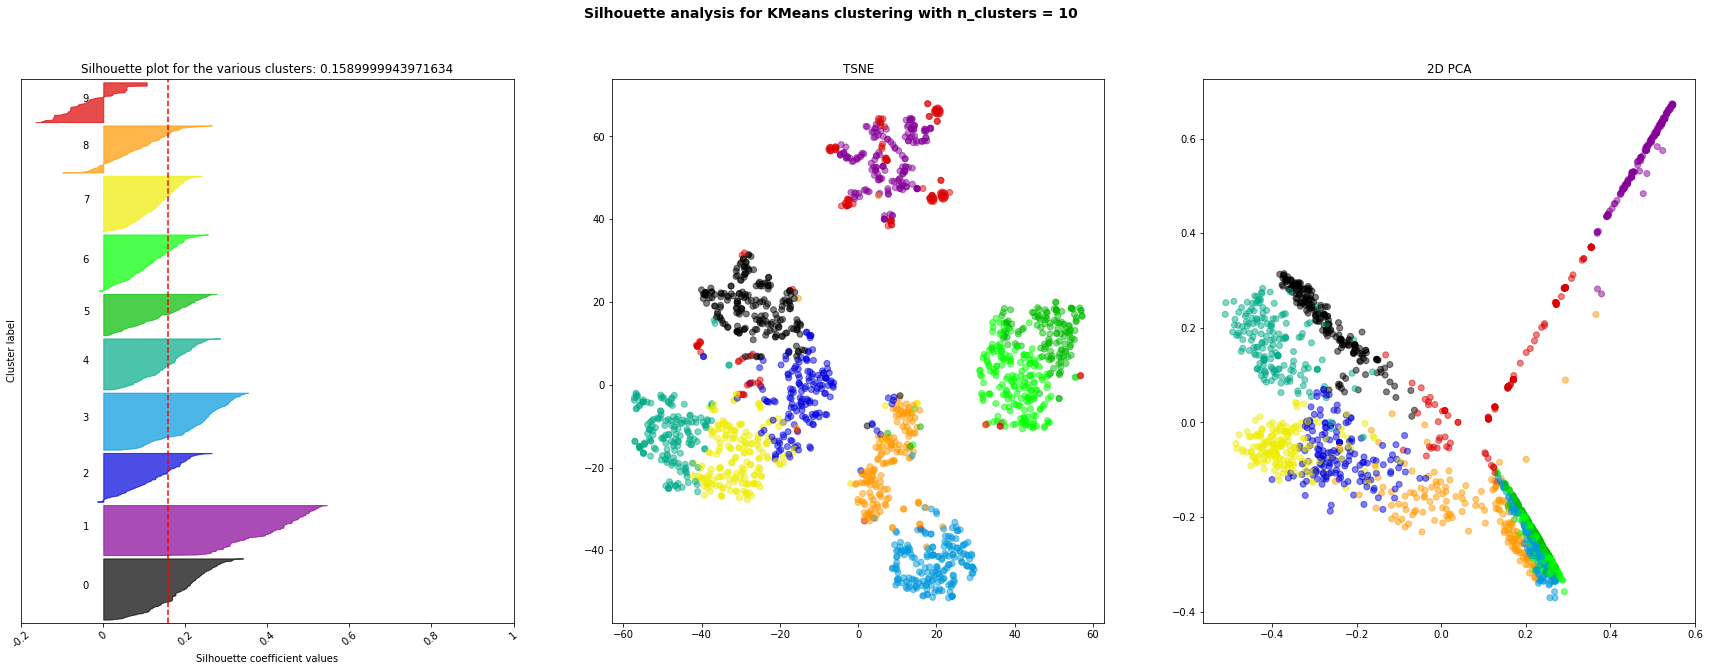

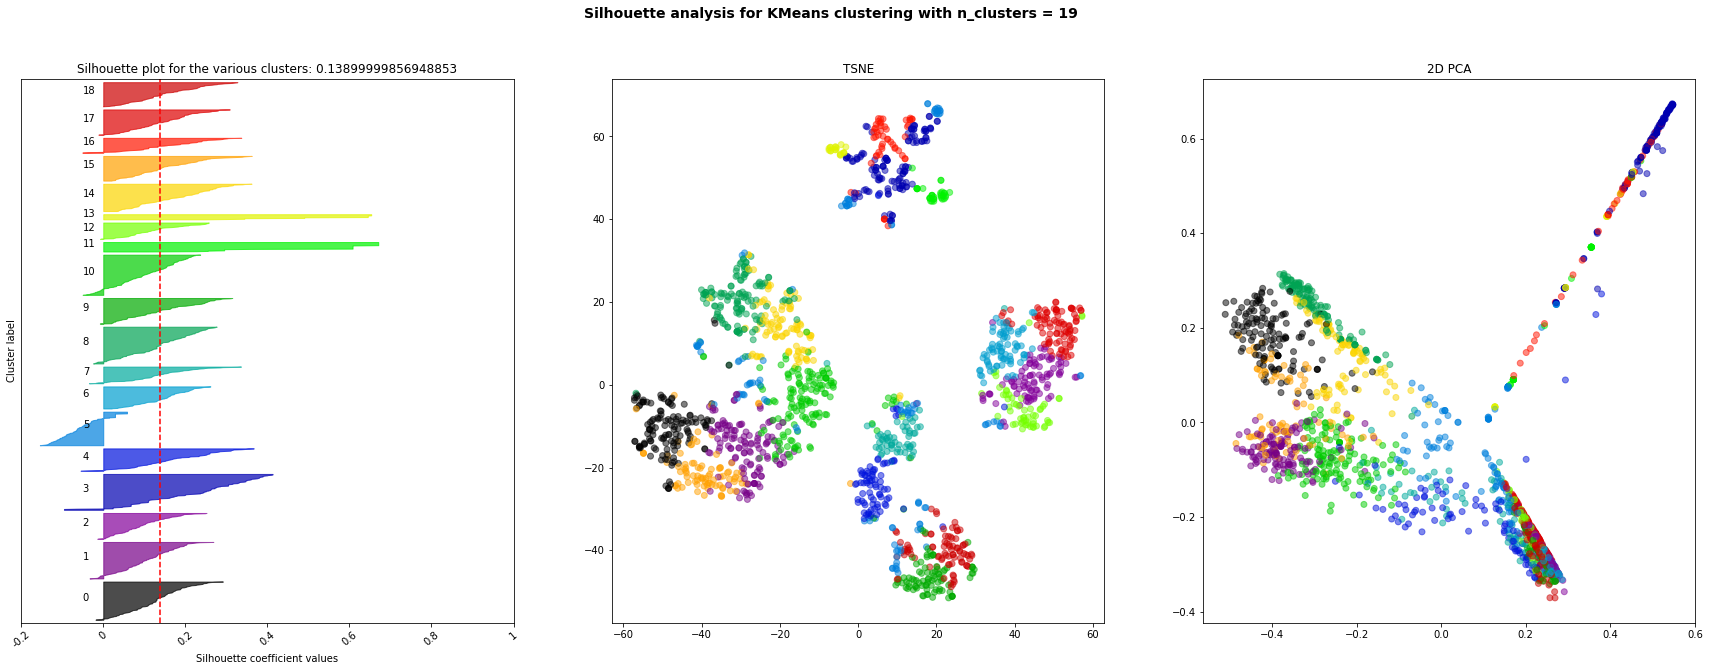

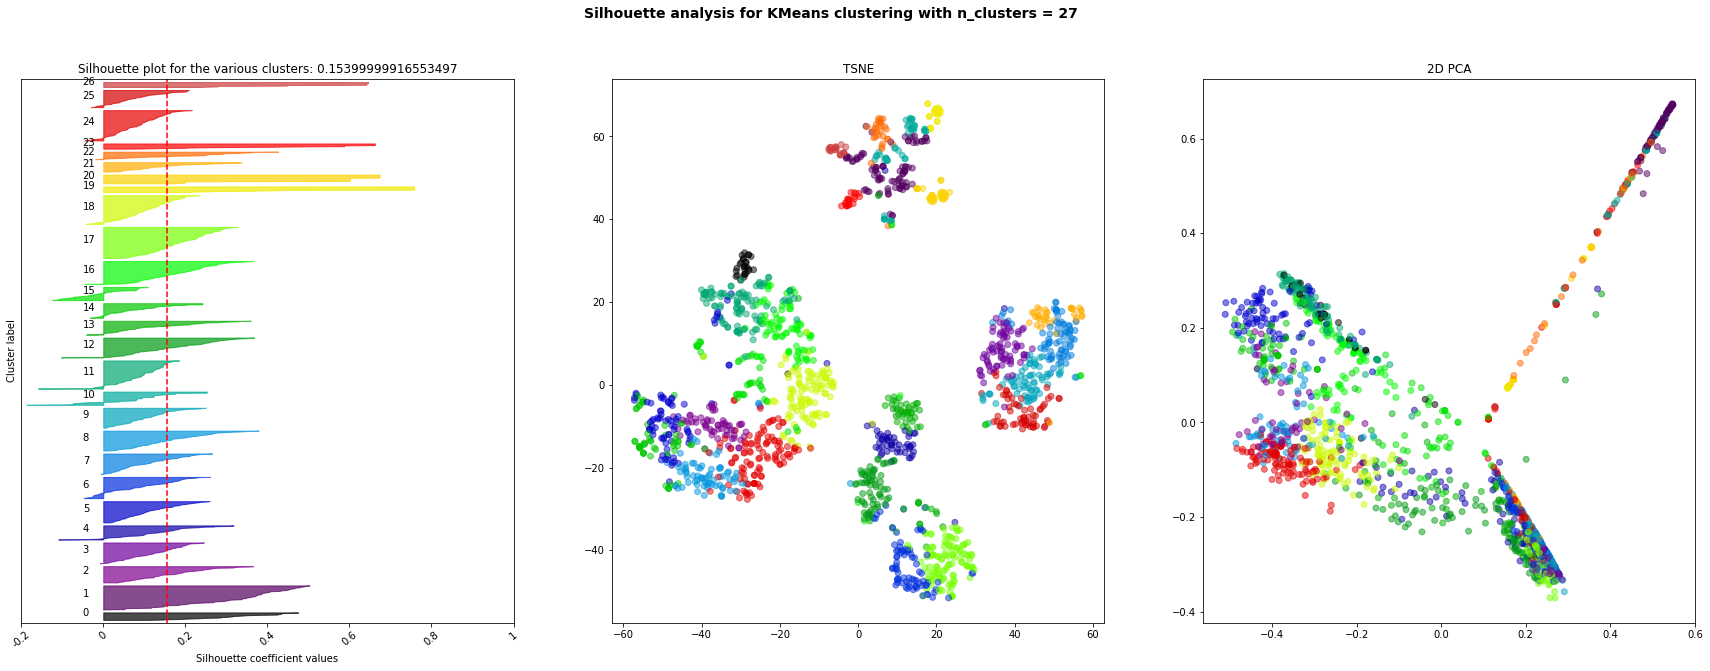

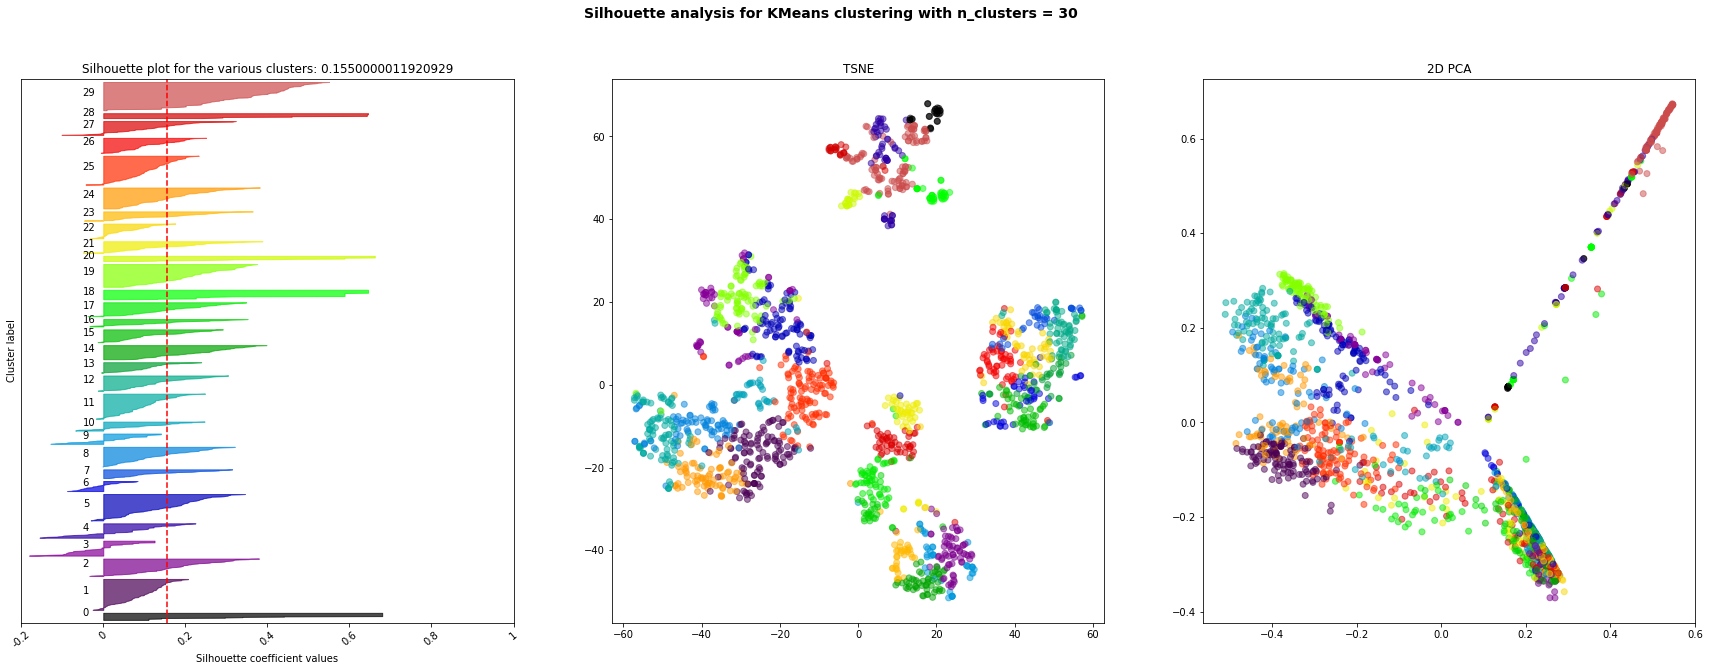

In [50]:
range_n_clusters = [10, 19, 27, 30]
silhouette_analysis(corpus_tfidf_dense, range_n_clusters)

In [121]:
d2v_df_scores, d2v_fitted_kmeans, d2v_labels_kmeans = evaluate_num_clusters(embeddings_d2v, plot=False)
d2v_df_scores

silhouette_score  calinski_harabasz_score  davies_bouldin_score
n_clusters                                                                 
10                  0.090647               118.103364              2.150988
11                  0.088744               111.164770              1.956655
12                  0.095399               105.778221              2.134724
13                  0.083722               103.295278              2.088506
14                  0.089204                97.564632              2.142112
15                  0.088254                94.363549              2.053983
16                  0.088128                91.135211              2.074222
17                  0.090734                87.894048              2.095248
18                  0.090747                85.402255              2.092423
19                  0.080040                81.663028              2.108967
20                  0.074289                79.576506              2.130819
21                  0.099355                78.902129              1.956451
22                  0.093834                76.964547              1.977718
23                  0.086247                75.219957              1.997147
24                  0.071657                73.100565              1.969182
25                  0.071842                71.150444              1.961127
26                  0.083046                68.637433              2.075069
27                  0.084112                68.148836              1.991860
28                  0.073775                66.048982              1.982808
29                  0.074184                64.203200              2.077009
30                  0.076511                63.616094              1.978350

N = 12, 17, 18, 21 seems to be the best, but overall worse than with BOW

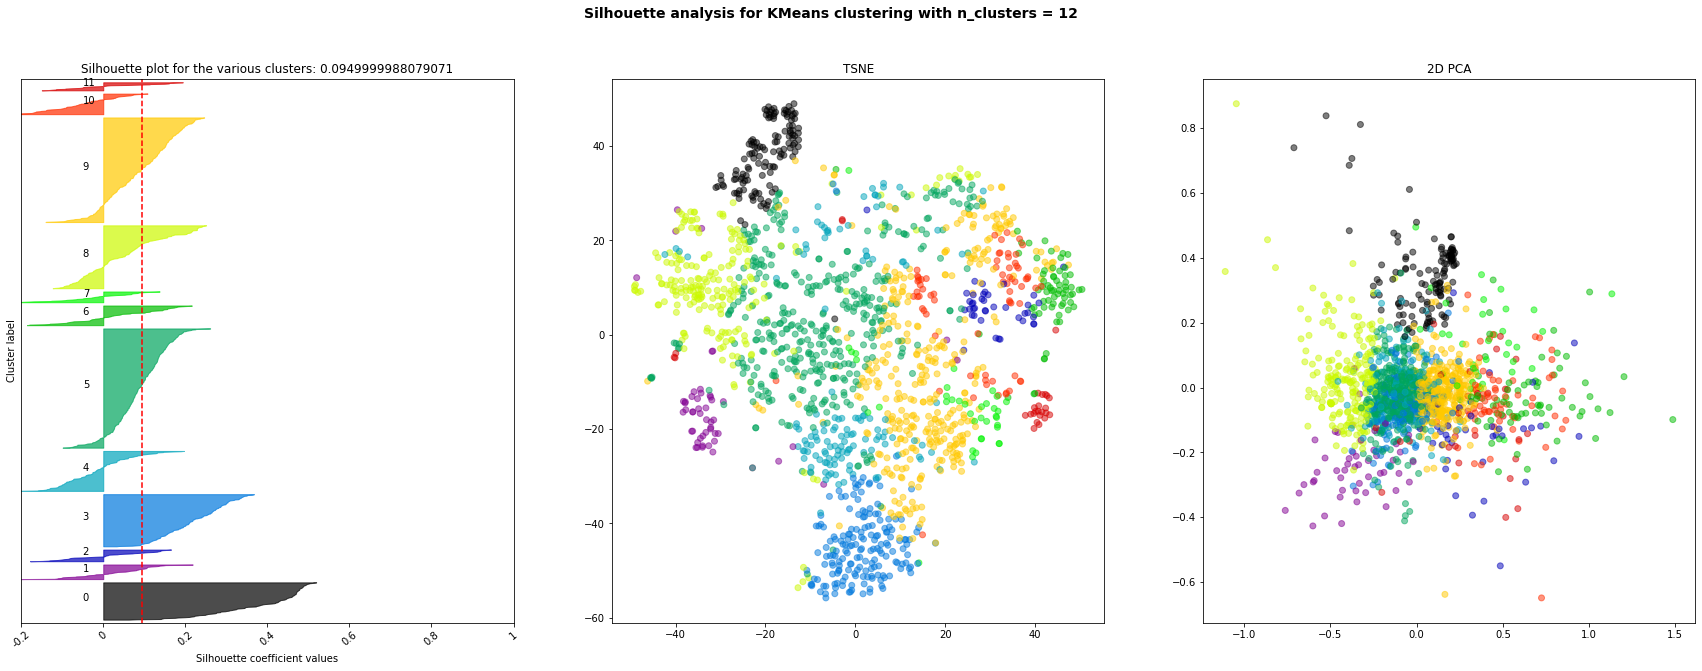

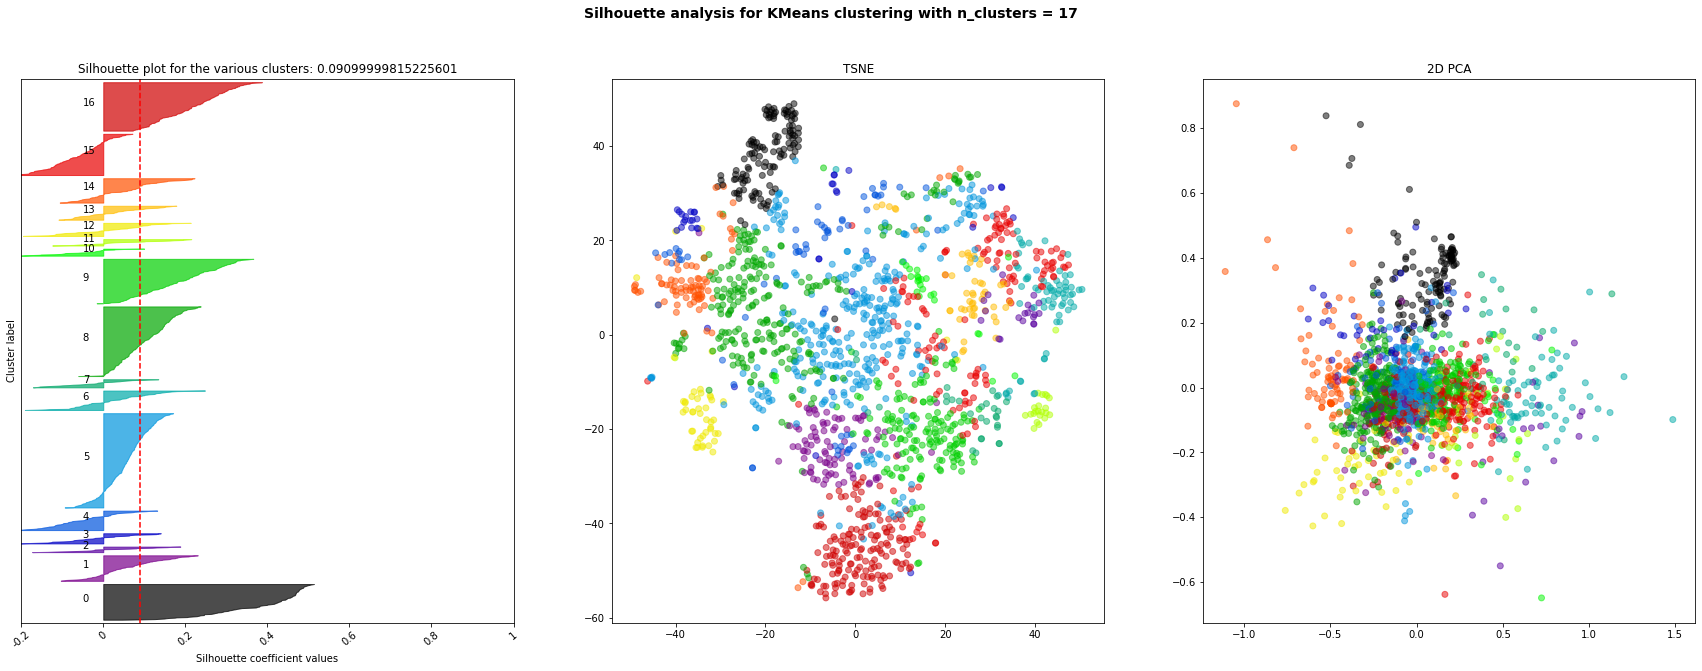

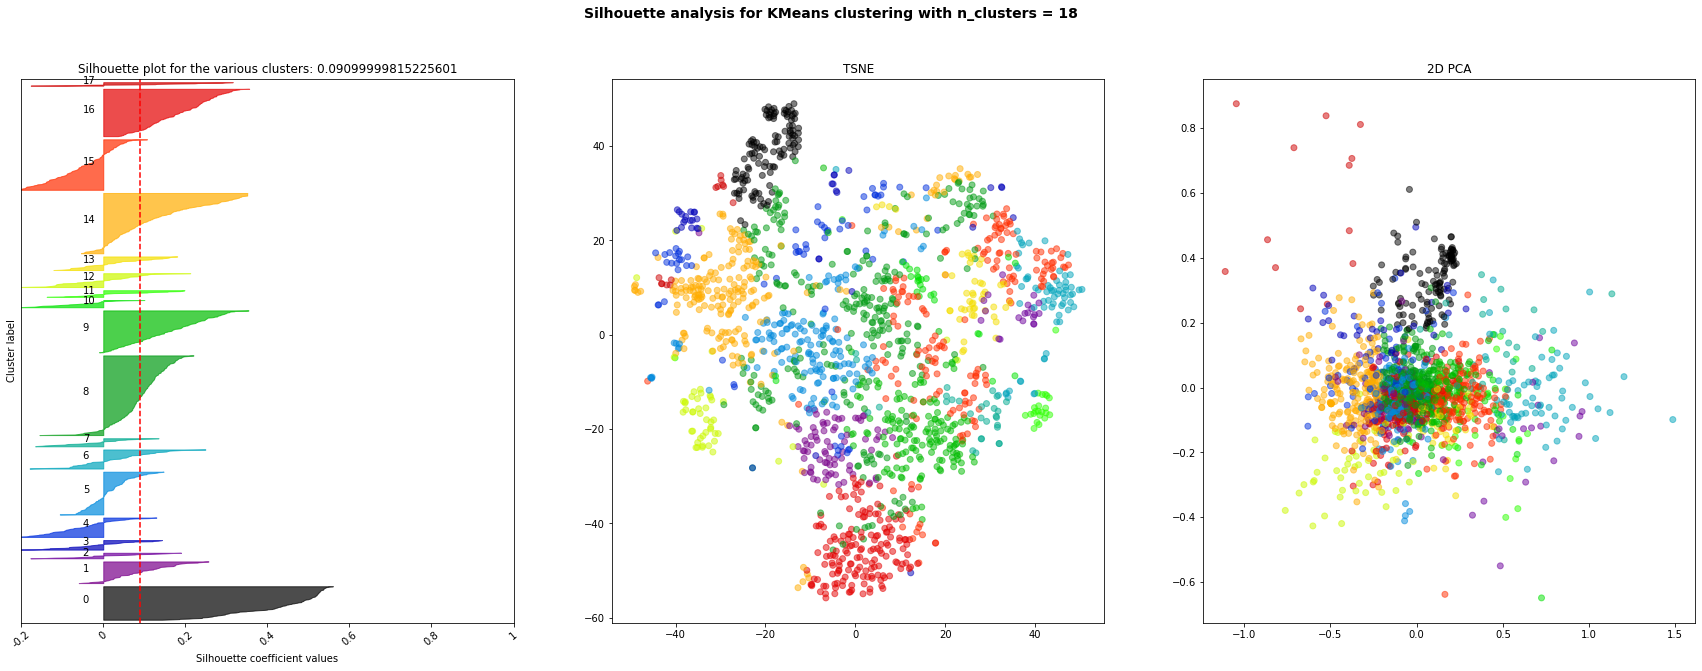

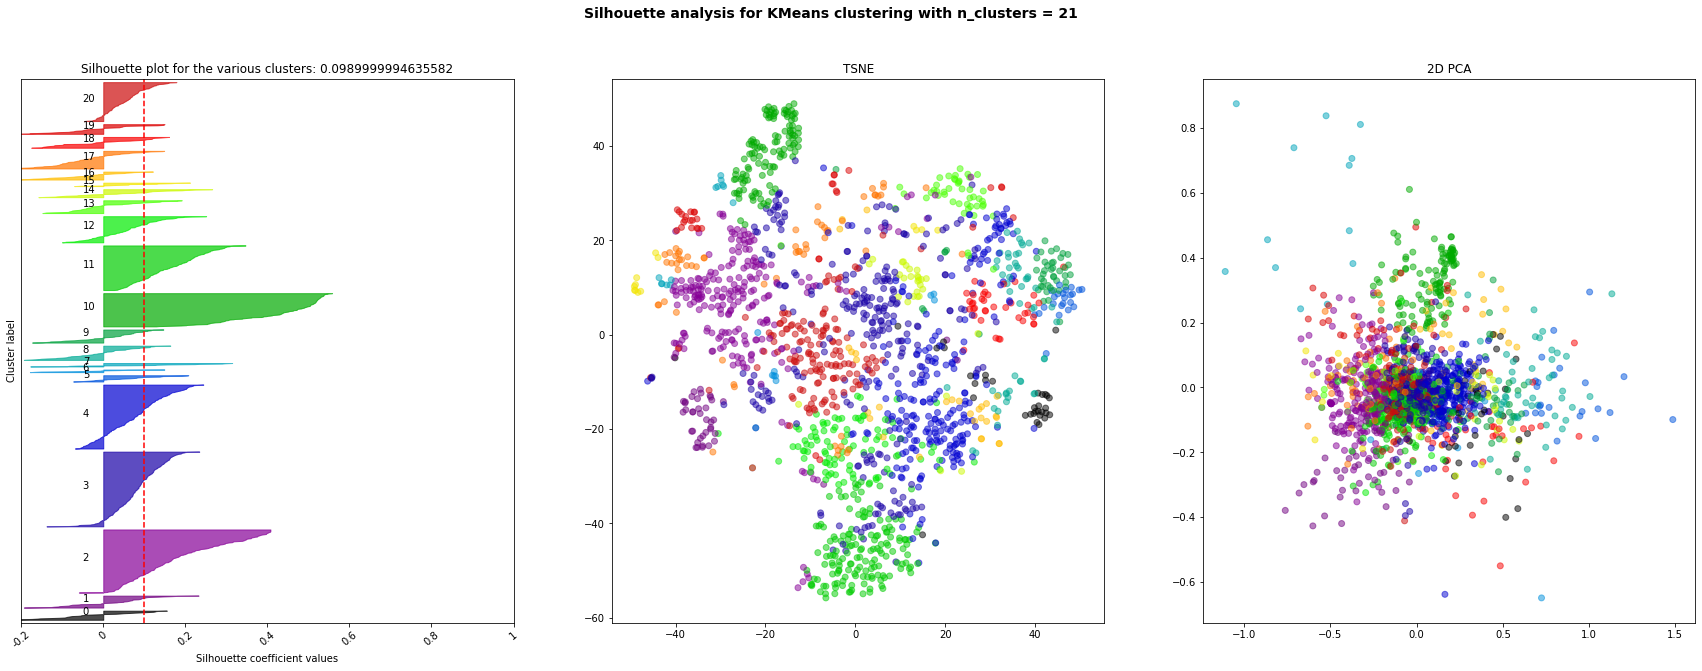

In [122]:
range_n_clusters = [12, 17, 18, 21]
silhouette_analysis(embeddings_d2v, range_n_clusters)

---

In [32]:
#########################################################################
# Train data
# DBscan clustering
#########################################################################

# The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. 
# Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped.
# https://scikit-learn.org/stable/modules/clustering.html#dbscan

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(metric='cosine', eps=0.8, min_samples=2)
clusters_bow = dbscan.fit_predict(corpus_tfidf_dense)
centroid_bow = dbscan.core_sample_indices_

dbscan = DBSCAN(metric='cosine', eps=0.1, min_samples=2)
clusters_d2v = dbscan.fit_predict(embeddings_d2v)
centroid_d2v = dbscan.core_sample_indices_

# Cluster = -1 -> Noise

In [33]:
# print("Mean Silhouette Coefficient - BOW: %0.3f" % silhouette_score(corpus_tfidf_dense, clusters_bow))
dbscan = DBSCAN(metric='cosine', eps=0.3, min_samples=2)
clusters_d2v = dbscan.fit_predict(embeddings_d2v)
centroid_d2v = dbscan.core_sample_indices_

print("Mean Silhouette Coefficient - D2V: %0.3f" % silhouette_score(embeddings_d2v, clusters_d2v))
np.unique(clusters_d2v)

Mean Silhouette Coefficient - D2V: -0.031


array([-1,  0,  1])

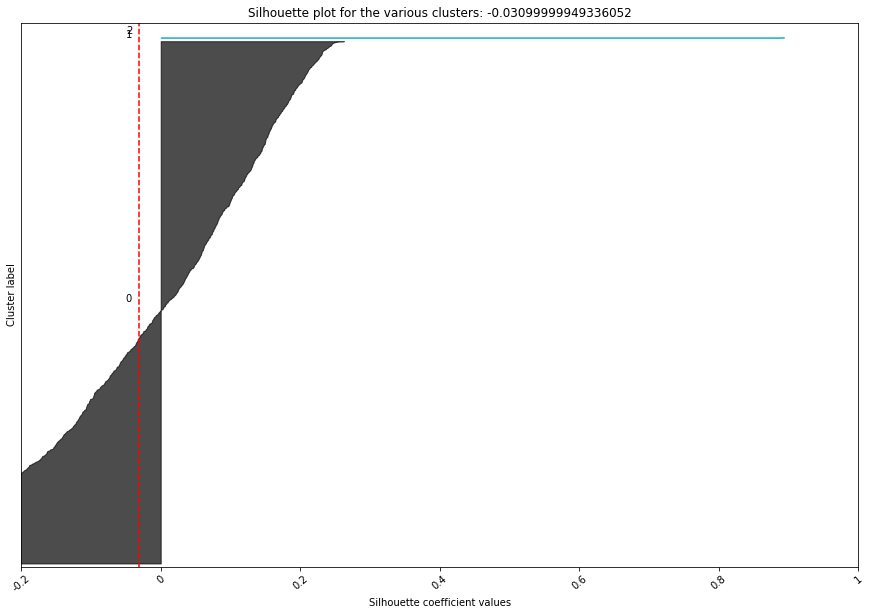

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

n_clusters = len(np.unique(clusters_d2v))
plot_silhouette(embeddings_d2v, n_clusters, clusters_d2v, ax)

plt.show()

---

In [35]:
#########################################################################
# Train data
# Agglomerative clustering
#########################################################################

from sklearn.cluster import AgglomerativeClustering

n_clusters = 30

# Define model
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None) # Compute all tree

clusters_bow = model.fit_predict(corpus_tfidf_dense)
# centroid_bow = model.cluster_centers_

clusters_d2v = model.fit_predict(embeddings_d2v)
# centroid_d2v = model.cluster_centers_

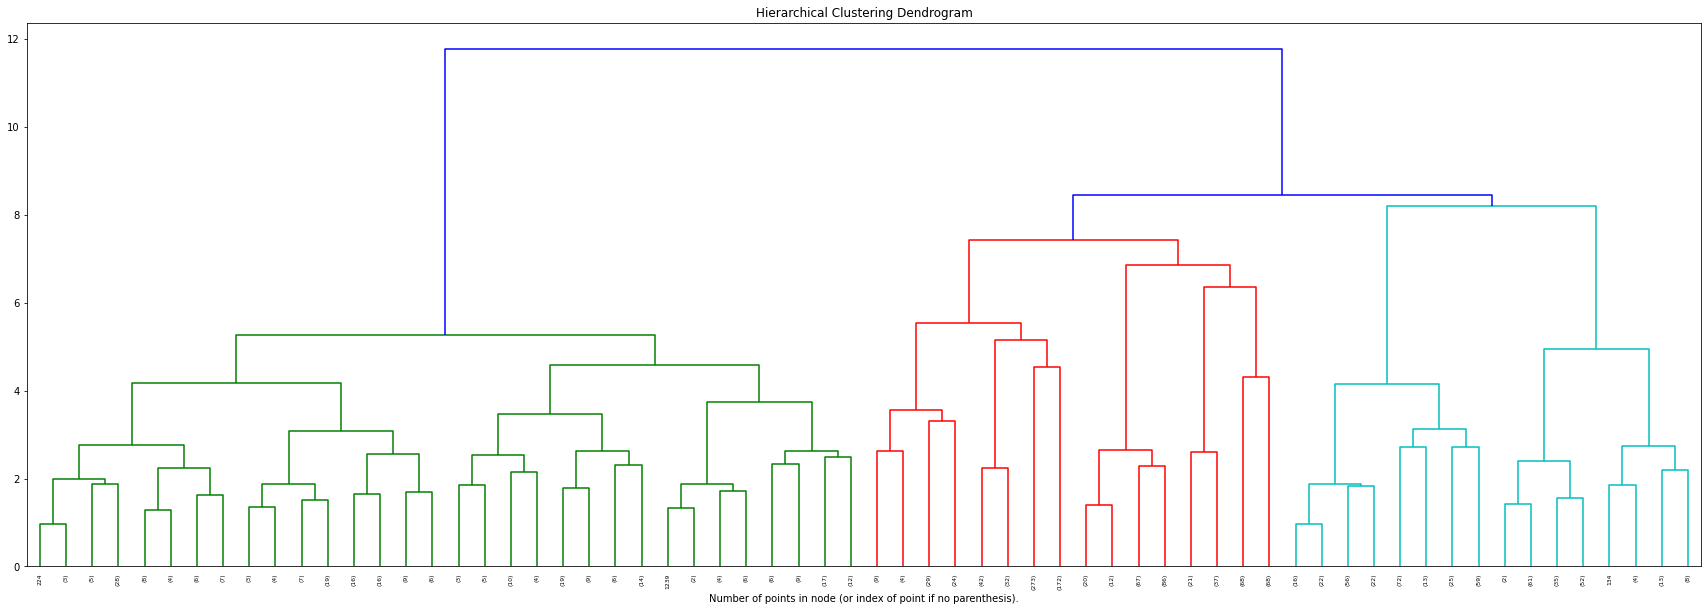

In [41]:
plt.subplots(1,1,figsize=(30,10))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

---

**The problem with LDA is that it gives the topic as a WORD, not a sequence**

But we could try to take the top_n topics for a document, decode them as a sequence and see if together they make sense as a cluster.

In [42]:
#########################################################################
# Train data
# Latent Dirichlet Allocation (LDA)
# https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
# https://radimrehurek.com/gensim/models/ldaseqmodel.html
#########################################################################

# Train LDA model.
from gensim.models import LdaModel

# Create input corpus and dictionary
dictionary = Dictionary(corpus_lists)

# TODO: CONSIDER FILTERING WORDS
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=0.2, no_above=0.7)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in corpus_lists]

In [43]:
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric

# Set training parameters.
num_topics = 10
chunksize = len(corpus_lists)
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

# Set callbacks
# https://www.meganstodel.com/posts/callbacks/
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
convergence_logger = ConvergenceMetric(logger='shell')
# coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = documents) # c_v vs u_mass ??
coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'u_mass')

lda = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    callbacks=[convergence_logger, perplexity_logger, coherence_cv_logger],
    random_state=12345
)

In [44]:
top_topics = lda.top_topics(corpus, topn=10)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

top_topics

Average topic coherence: -3.7341.


[([(0.105702735, '1-0-3-2-0-1'),
   (0.103066675, '1-0-3-1-0-1'),
   (0.06797595, '3-0-3-2-0-1'),
   (0.06189185, '3-0-3-1-0-1'),
   (0.05701139, '1-0-0-2-0-1'),
   (0.052465435, '0-0-3-1-3-1'),
   (0.051888105, '1-0-0-1-0-1'),
   (0.044234436, '1-0-2-3-0-1'),
   (0.037470207, '0-0-0-1-3-1'),
   (0.037470203, '0-0-0-2-4-1')],
  -0.4242312947246745),
 ([(0.12777938, '1-0-2-2-0-1'),
   (0.12148946, '1-0-2-1-0-1'),
   (0.0764043, '1-0-3-3-0-1'),
   (0.07429817, '3-0-2-1-0-1'),
   (0.07075038, '3-0-2-2-0-1'),
   (0.06747859, '1-0-0-3-0-1'),
   (0.06076217, '0-0-2-1-3-1'),
   (0.060762115, '0-0-2-2-4-1'),
   (0.042365298, '3-0-3-3-0-1'),
   (0.03798332, '0-0-0-3-2-1')],
  -0.6142086680805722),
 ([(0.16363075, '1-1-0-1-0-1'),
   (0.14317122, '1-1-0-2-0-1'),
   (0.09437997, '3-1-0-1-0-1'),
   (0.087331355, '0-1-0-1-3-1'),
   (0.085888684, '0-1-0-2-4-1'),
   (0.06945099, '3-1-0-2-0-1'),
   (0.060826268, '0-1-0-1-1-1'),
   (0.042141173, '1-1-2-1-0-1'),
   (0.041314162, '0-1-0-2-1-1'),
   (0.039

In [47]:
# Get decoded topics

# Get list of topics (each one is a list of activities)
aux = [t[0] for t in top_topics]

topic_list = []
for t in aux:
  topic_list.append([x[1] for x in t])

decoded_topics = []
# Decode topics
for topic in topic_list:
  decoded_t = v_undo_encoding(topic)
  orig_t = ordinalencoder_X.inverse_transform(decoded_t)
  decoded_topics.append(orig_t)

cols = ['Activity', 'DayType', 'Sequence', 'BreakType', 'Token', 'Legal']

df_centroids = pd.DataFrame(columns=cols)

for c, number in zip(decoded_topics, range(len(decoded_topics))):
  df_c = pd.DataFrame(c, columns=cols)
  df_c["Topic"] = number

  df_centroids = df_centroids.append(df_c)

df_centroids.iloc[:20]

Activity DayType Sequence      BreakType Token Legal  Topic
0  Driving     edd    third        split_2     A     1    0.0
1  Driving     edd    third        split_1     A     1    0.0
2    Other     edd    third        split_2     A     1    0.0
3    Other     edd    third        split_1     A     1    0.0
4  Driving     edd    first        split_2     A     1    0.0
5    Break     edd    third        split_1  B_T2     1    0.0
6  Driving     edd    first        split_1     A     1    0.0
7  Driving     edd   second  uninterrupted     A     1    0.0
8    Break     edd    first        split_1  B_T2     1    0.0
9    Break     edd    first        split_2  B_T3     1    0.0
0  Driving     edd   second        split_2     A     1    1.0
1  Driving     edd   second        split_1     A     1    1.0
2  Driving     edd    third  uninterrupted     A     1    1.0
3    Other     edd   second        split_1     A     1    1.0
4    Other     edd   second        split_2     A     1    1.0
5  Driving     edd    first  uninterrupted     A     1    1.0
6    Break     edd   second        split_1  B_T2     1    1.0
7    Break     edd   second        split_2  B_T3     1    1.0
8    Other     edd    third  uninterrupted     A     1    1.0
9    Break     edd    first  uninterrupted  B_T1     1    1.0

LDA is not properly trained, but at this point I can see that topics are not fully interpretable. The activities by itself seems coherent, but not the order in which are displayed (this is due to the coherence value of each topic)

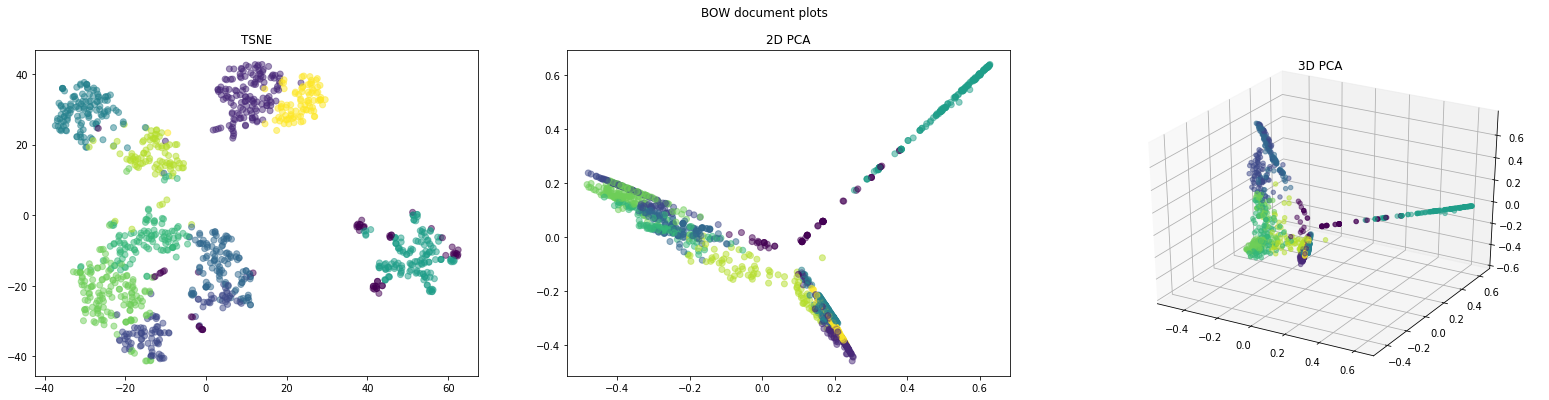

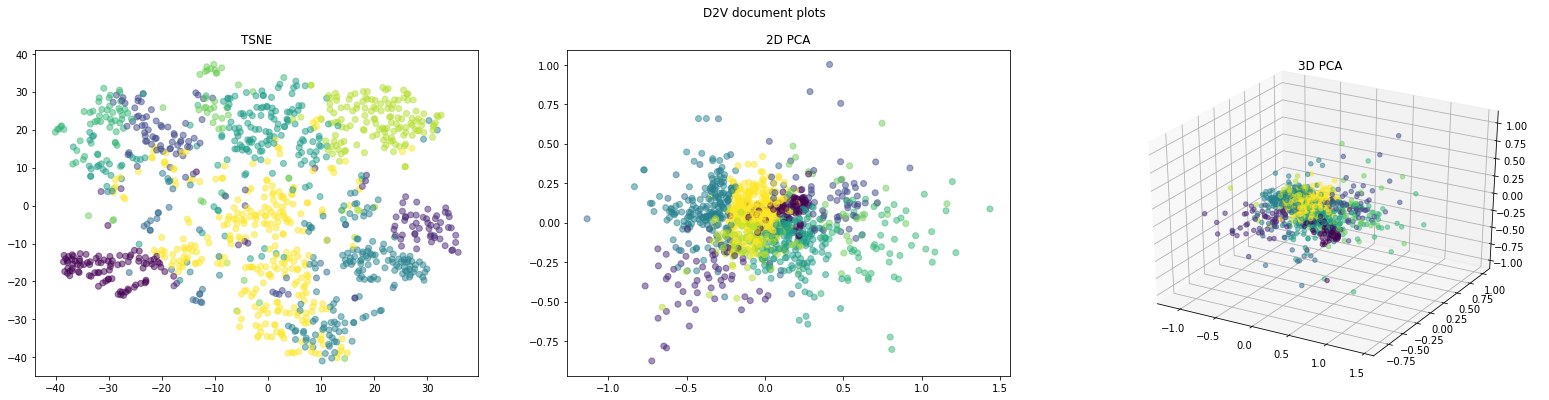

In [ ]:
#########################################################################
# Plot clustered data
#########################################################################

visualize_data(corpus_tfidf_dense, 'BOW', clusters_bow)
visualize_data(embeddings_d2v, 'D2V', clusters_d2v)

In [ ]:
#########################################################################
# Get decoded centroids for Doc2Vec
#########################################################################

decoded_centroids_d2v = get_decoded_centroids_d2v(centroid_d2v)
decoded_centroids_d2v

Activity DayType Sequence      BreakType  Token Legal  Cluster
0   Driving     ndd   unique  uninterrupted      A     1      0.0
1     Other     ndd   unique  uninterrupted      A     1      0.0
2   Driving     ndd   unique  uninterrupted      A     1      0.0
3     Break     ndd   unique  uninterrupted  DR_T4     1      0.0
0   Driving    none     none           none      A     0      1.0
..      ...     ...      ...            ...    ...   ...      ...
6     Other     ndd   unique  uninterrupted      A     1      9.0
7   Driving     ndd   unique  uninterrupted      A     1      9.0
8     Other     ndd   unique  uninterrupted      A     1      9.0
9   Driving     ndd   unique  uninterrupted      A     1      9.0
10    Break     ndd   unique  uninterrupted  WR_T1     1      9.0

[145 rows x 7 columns]

In [ ]:
# Print results

# NOTE: Select here which clusters show
clusters = clusters_d2v

groups = df2.groupby(['Driver','Day'], sort=False)

results = []
for (name, group), cluster in zip(groups, clusters):
  results.append("{} in day {}: {}".format(name[0], int(name[1]), cluster))

# results

In [132]:
#########################################################################
# Save results
#########################################################################

# NOTE: Select here which clusters save
# clusters = clusters_d2v
# clusters = bow_labels_kmeans[19]
clusters = d2v_labels_kmeans[21]

# Final dataset columns
cols = df_original.columns.to_numpy()
cols = np.insert(cols, -1, 'Cluster')

df_out = pd.DataFrame(columns=cols)

groups = df_original.groupby(['Driver','Day'], sort=False)

# Add clusters to log
for (name, group), cluster in zip(groups, clusters):
  group["Cluster"] = cluster
  df_out = df_out.append(group)

df_out

Driver       DateTimeStart  ... Cluster  ZenoInfo
0        driver1 2017-02-01 17:59:00  ...      12       NaN
1        driver1 2017-02-01 18:13:00  ...      12       NaN
2        driver1 2017-02-01 18:16:00  ...      12       NaN
3        driver1 2017-02-01 18:18:00  ...      12       NaN
4        driver1 2017-02-01 18:20:00  ...      12       NaN
...          ...                 ...  ...     ...       ...
27163  driver188 2017-01-15 03:30:00  ...       2       NaN
27164  driver188 2017-01-15 08:22:00  ...       3       NaN
27165  driver188 2017-01-15 08:32:00  ...       3       NaN
27166  driver188 2017-01-15 08:37:00  ...       3       NaN
27167  driver188 2017-01-15 08:54:00  ...       3       NaN

[27168 rows x 14 columns]

In [133]:
!mkdir results

# Save as CSV
df_out.to_csv("results/log-clustering.csv", sep="\t", index=False)

# Save each cluster separated
groups = df_out.groupby(['Cluster'], sort=False)

# Add clusters to log
for name, group in groups:
  cluster = group['Cluster'].to_numpy()[0]
  
  path = "results/log-clustering-c{}.csv".format(cluster)
  group.to_csv(path, sep="\t", index=False)

mkdir: cannot create directory ‘results’: File exists


In [134]:
!zip -r results.zip results

from google.colab import files
files.download("results.zip")

updating: results/ (stored 0%)
updating: results/log-clustering-c11.csv (deflated 88%)
updating: results/log-clustering-c6.csv (deflated 88%)
updating: results/log-clustering-c4.csv (deflated 88%)
updating: results/log-clustering-c9.csv (deflated 88%)
updating: results/log-clustering-c12.csv (deflated 88%)
updating: results/log-clustering-c13.csv (deflated 87%)
updating: results/log-clustering-c17.csv (deflated 88%)
updating: results/log-clustering-c5.csv (deflated 88%)
updating: results/log-clustering.csv (deflated 88%)
updating: results/log-clustering-c7.csv (deflated 88%)
updating: results/log-clustering-c0.csv (deflated 89%)
updating: results/log-clustering-c18.csv (deflated 88%)
updating: results/log-clustering-c3.csv (deflated 88%)
updating: results/log-clustering-c14.csv (deflated 88%)
updating: results/log-clustering-c1.csv (deflated 87%)
updating: results/log-clustering-c8.csv (deflated 88%)
updating: results/log-clustering-c16.csv (deflated 88%)
updating: results/log-clusteri

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save d2v centroids
decoded_centroids_d2v.to_csv("log-clustering-centroids.csv", sep="\t", index=False)
files.download("log-clustering-centroids.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>